# CHSH Spiel

In [22]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt
from qiskit.quantum_info import Operator, DensityMatrix, state_fidelity
from itertools import product
import ipywidgets as widgets
from IPython.display import display

## Spielregeln
1. Zwei Spieler (Alice und Bob) sind getrennt und können nicht miteinander kommunizieren
2. Jeder erhält ein zufälliges Bit (0 oder 1)
3. Sie müssen jeweils ein Bit ausgeben (0 oder 1)
4. Sie gewinnen, wenn: a ⊕ b = x-y 
   wobei:
   - a ist die Ausgabe von Alice
   - b die Ausgabe von Bob ist
   - x ist die Eingabe an Alice
   - y ist die Eingabe an Bob
   - ⊕ ist XOR (Addition modulo 2)
   - ist AND (Multiplikation)

In [23]:
def evaluate_game(a, b, x, y):
    """
    Evaluates if players win the CHSH game for given inputs and outputs
    
    Args:
        a (int): Alice's output (0 or 1)
        b (int): Bob's output (0 or 1)
        x (int): Alice's input (0 or 1)
        y (int): Bob's input (0 or 1)
    
    Returns:
        bool: True if players win, False otherwise
    """
    return (a ^ b) == (x & y)

## Klassische Strategie

Alice und Bob besprechen vor Spielbeginn eine Strategie

In [24]:
def simulate_classical_game(num_trials=1024):
    """
    Simulates the classical CHSH game strategy
    """
    a = int(input("Enter the value for a (0 or 1): "))
    if a not in [0, 1]:
        raise ValueError("Invalid value for a. Must be 0 or 1.")
    b = int(input("Enter the value for b (0 or 1): "))
    if b not in [0, 1]:
        raise ValueError("Invalid value for b. Must be 0 or 1.")
    
    # Optimal classical strategy
    # a = ?
    # b = ?

    wins = 0
    for _ in range(num_trials):
        x = np.random.randint(2)
        y = np.random.randint(2)
        if evaluate_game(a, b, x, y):
            wins += 1
    return wins / num_trials

# Run classical simulation
classical_win_rate = simulate_classical_game()
print(f"Classical Strategy Win Rate: {classical_win_rate:.3f}")
print(f"Theoretical Win Rate: 0.750")

Classical Strategy Win Rate: 0.782
Theoretical Win Rate: 0.750


## Quantenstrategie

Anna und Bob rotieren ihr Qbit abhängig von ihrem erhaltenen x und y.
Durch schlaues rotieren lässt sich die Gewinnwahrscheinlichkeit erhöhen.

**Achtung** y-Gate in qiskit is definiert wie folgt:  
$$
RY(\theta) = \exp\left(-i \frac{\theta}{2} Y\right) = \begin{pmatrix} \cos\left(\frac{\theta}{2}\right) & \sin\left(\frac{\theta}{2}\right) \\ -\sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right) \end{pmatrix}
$$


In [25]:
def create_chsh_circuit(x, y):
    """
    Creates a quantum circuit implementing the optimal CHSH strategy
    """
    qr = QuantumRegister(2, 'q')
    cr = ClassicalRegister(2, 'c')
    qc = QuantumCircuit(qr, cr)
    
    # Create Bell state |Φ⁺⟩ = (|00⟩ + |11⟩)/√2
    qc.h(0)
    qc.cx(0, 1)
    qc.barrier()

    # Alice changes rotation of her qubit based on input x
    if x == 0:
        qc.ry(0, 0)
    else:
        qc.ry(2*np.pi/4, 0) # Intended angle is mulitplied by 2 because the y-Gate in Qiskit uses theta/2
    
    # Bob changes rotation of his qubit based on input y
    if y == 0:
        qc.ry(2*np.pi/8, 1)
    else:
        qc.ry(2*-np.pi/8, 1)

    qc.barrier()
    qc.measure(qr, cr)
    
    return qc

def run_chsh_circuit(x, y, shots=1024):
    """
    Performs measurements with noise mitigation techniques
    """
    qc = create_chsh_circuit(x, y)
    simulator = AerSimulator()
    job = simulator.run(qc, shots=shots)
    result = job.result()
    return result.get_counts()

def quantum_game_simulation(shots_per_input=1024):
    """
    Simulates the quantum CHSH game
    Expected win rate: ~85% (optimal quantum strategy)
    """
    total_wins = 0
    total_shots = 0
    results = {}
    
    for x, y in product([0, 1], repeat=2):
        counts = run_chsh_circuit(x, y, shots_per_input)
        wins = 0
        
        for outcome, count in counts.items():
            a, b = map(int, outcome)
            if (a ^ b) == (x & y):
                wins += count
            total_shots += count
        
        win_rate = wins / shots_per_input
        results[(x, y)] = win_rate
        total_wins += wins
    
    return total_wins / total_shots

# Run quantum simulation
quantum_win_rate = quantum_game_simulation()
print(f"\nQuantum Strategy Win Rate: {quantum_win_rate:.3f}")
print(f"Theoretical Quantum Win Rate: {(1 + 1/np.sqrt(2))/2:.3f}")


Quantum Strategy Win Rate: 0.860
Theoretical Quantum Win Rate: 0.854


## Visualisierung der Ergebnisse

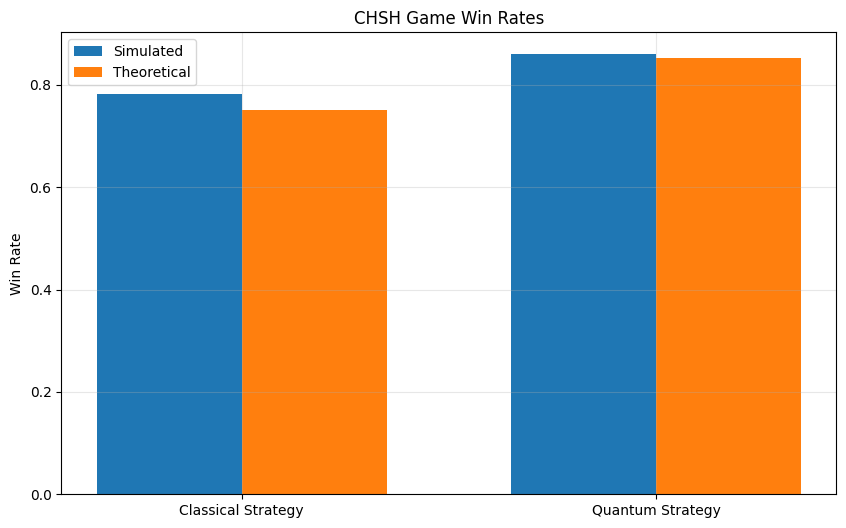

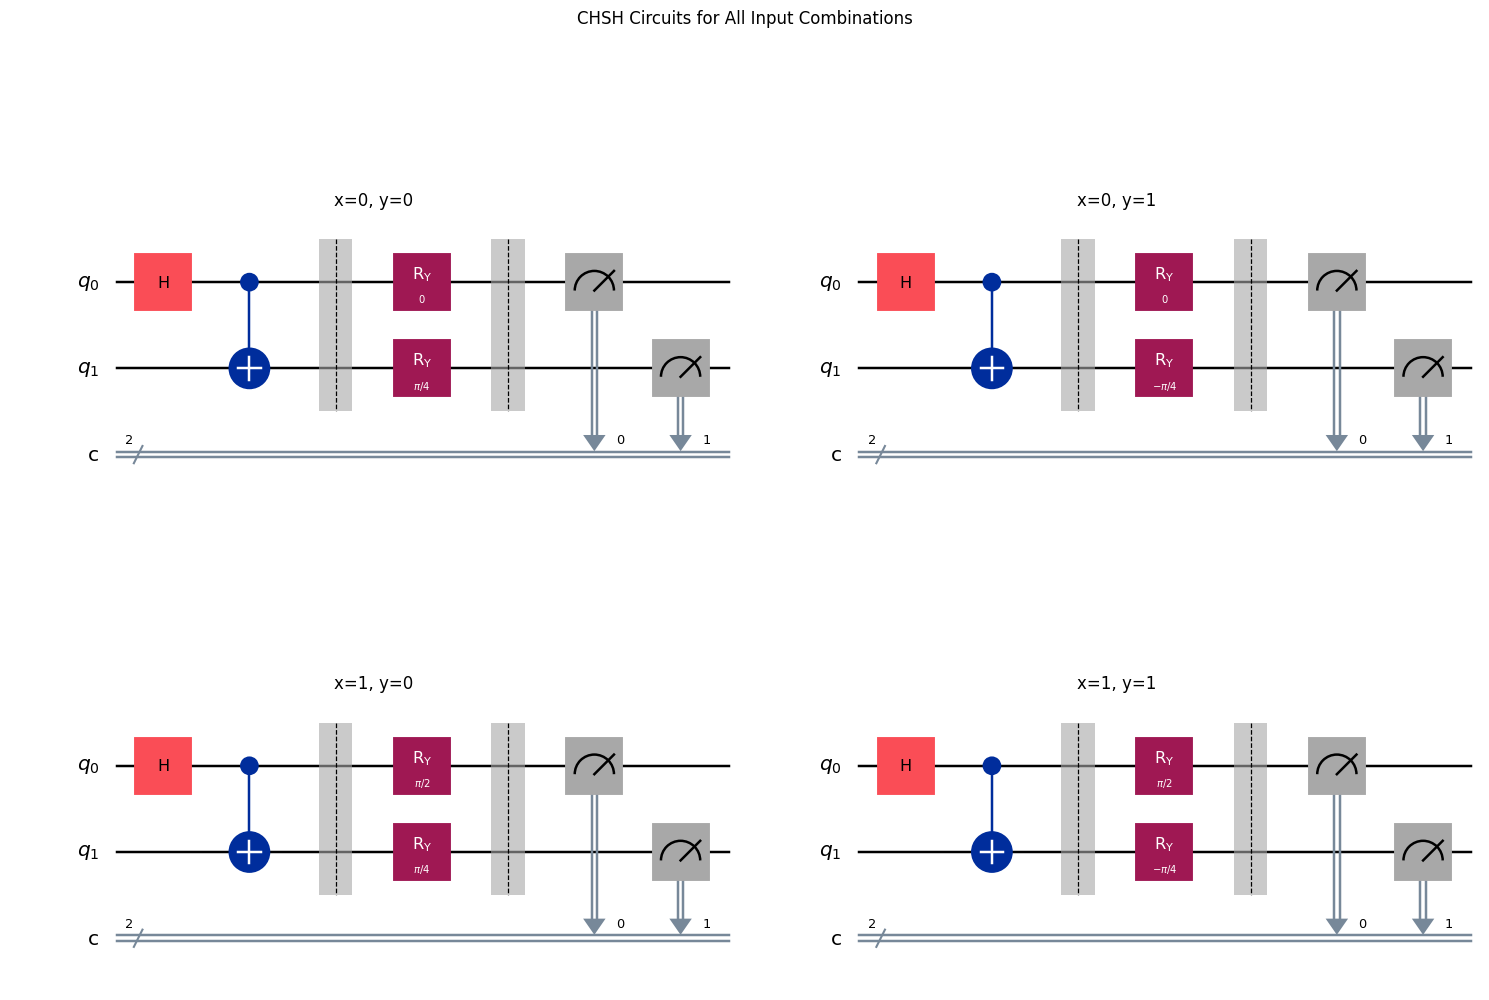

In [26]:
def plot_comparison(classical_rate, quantum_rate):
    """
    Creates a bar plot comparing classical and quantum win rates
    """
    labels = ['Classical Strategy', 'Quantum Strategy']
    values = [classical_rate, quantum_rate]
    theoretical = [0.75, (1 + 1/np.sqrt(2))/2]
    
    plt.figure(figsize=(10, 6))
    x = np.arange(len(labels))
    width = 0.35
    
    plt.bar(x - width/2, values, width, label='Simulated')
    plt.bar(x + width/2, theoretical, width, label='Theoretical')
    
    plt.ylabel('Win Rate')
    plt.title('CHSH Game Win Rates')
    plt.xticks(x, labels)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    return plt.gcf()

def plot_all_circuits():
    """
    Visualizes circuits for all possible input combinations
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('CHSH Circuits for All Input Combinations')
    
    for i, (x, y) in enumerate(product([0, 1], repeat=2)):
        ax = axes[i//2, i%2]
        qc = create_chsh_circuit(x, y)
        circuit_drawer(qc, output='mpl', style={'backgroundcolor': '#FFFFFF'}, ax=ax)
        ax.set_title(f'x={x}, y={y}')
    
    plt.tight_layout()
    return fig

plot_comparison(classical_win_rate, quantum_win_rate)
plt.show()

plot_all_circuits()
plt.show()

## 

In [27]:
def calculate_correlation(counts, total):
    """
    Calculates the quantum correlation value from measurement results
    For each measurement outcome:
    - Convert bits (0,1) to spin values (+1,-1)
    - Calculate the product A·B
    - Weight by probability of outcome
    """
    correlation = 0
    for outcome, count in counts.items():
        a, b = map(int, outcome)
        # Convert from {0,1} to {+1,-1}
        A = (-1)**a
        B = (-1)**b
        correlation += (A * B) * count/total
    return correlation


def calculate_chsh_parameter(shots=1000):
    """
    Calculates the CHSH parameter S = |⟨A₀B₀⟩ + ⟨A₀B₁⟩ + ⟨A₁B₀⟩ - ⟨A₁B₁⟩|
    
    Classical bound: |S| ≤ 2
    Quantum bound: |S| ≤ 2√2 ≈ 2.828 (Tsirelson's bound)
    """
    correlations = {}
    
    for x, y in product([0,1], repeat=2):
        counts = run_chsh_circuit(x, y, shots)
        correlations[(x,y)] = calculate_correlation(counts, shots)
    
    S = (correlations[(0,0)] + correlations[(0,1)] + 
         correlations[(1,0)] - correlations[(1,1)])
    
    return abs(S)


# Calculate CHSH parameter
chsh_parameter = calculate_chsh_parameter()
print(f"\nCalculated CHSH parameter: {chsh_parameter:.3f}")
print(f"Theoretical quantum maximum (2√2): {2*np.sqrt(2):.3f}")
print(f"Classical bound: 2.000")


Calculated CHSH parameter: 2.832
Theoretical quantum maximum (2√2): 2.828
Classical bound: 2.000
